In [1]:
# Modify the file A00_setup.  Note the working directory is changed
import os
os.chdir(os.getcwd().rsplit(os.path.sep + 'code')[0] + os.path.sep + 'code')
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./_A_embeddings/A00_setup.py").load_module()

# Datasets for future work 
  * Simplified datset with only codes with descriptions and selected original features
  * NAICS Embedding K-Means 20 and 100 - (Model A01)


In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import importlib, pickle

In [3]:
import matplotlib.pyplot as plt
from sba_nn.sba_nn import sbnn_plot, sbnn_embed
import matplotlib.ticker as ticker
import textwrap

In [4]:
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

In [5]:
import seaborn as sns

In [6]:
sbnn_plot.plot_defaults()

## Import Data

##### Loans

In [7]:
sba_loans = pd.read_parquet(Path(setup.parent_path).joinpath('01_DATA_transformed_nomiss.parquet'))

##### NAICS descriptions

In [8]:
# Only level 6 are needed
naics_desc = pd.read_parquet('./naics/naics_desc_wide.parquet')
naics_desc = naics_desc[naics_desc['NAICS_level'] == 6].drop_duplicates('NAICS')

##### Embeddings

In [9]:
emb_all = pd.read_parquet(Path(setup.temp_path).joinpath('A10_DATA_embeddings.parquet'))
emb_all = emb_all[emb_all['model'] == 'A01'] \
    .sort_values('NAICS_orig') \
    .reset_index(drop=True)

In [10]:
emb_all.head(2)

,NAICS_orig,emb_00,emb_01,emb_02,emb_03,emb_04,emb_05,emb_06,emb_07,dset_naics_holdout,NAICS_4_orig,NAICS_3_orig,NAICS_sector_orig,model
0,111110,0.829431,-0.429467,-0.846687,-0.688373,0.833410,0.827503,-0.919467,0.813810,0.0,1111,111,11,A01
1,111120,0.230878,-0.260833,-0.291354,-0.539546,0.470609,0.598844,-0.677097,0.253074,0.0,1111,111,11,A01


In [11]:
emb_features = [c for c in emb_all if c.startswith('emb_')]
print(emb_features)

['emb_00', 'emb_01', 'emb_02', 'emb_03', 'emb_04', 'emb_05', 'emb_06', 'emb_07']


##### TSNE
Merge with embeddings

In [12]:
tsne_df = pd.read_parquet(Path(setup.temp_path).joinpath('A10_DATA_embed_tsne.parquet')) \
    [['model', 'NAICS_orig', 'tsne_0', 'tsne_1']] 
tsne_df = tsne_df[tsne_df['model'] == 'A01'] \
    .drop(columns='model') \
    .merge(emb_all, on='NAICS_orig', how='left') \
    .sort_values('NAICS_orig') \
    .reset_index(drop=True) 

In [13]:
tsne_df.head()

,NAICS_orig,tsne_0,tsne_1,emb_00,emb_01,emb_02,emb_03,emb_04,emb_05,emb_06,emb_07,dset_naics_holdout,NAICS_4_orig,NAICS_3_orig,NAICS_sector_orig,model
0,111110,-56.944935,2.719548,0.829431,-0.429467,-0.846687,-0.688373,0.833410,0.827503,-0.919467,0.813810,0.0,1111,111,11,A01
1,111120,-25.674465,15.965102,0.230878,-0.260833,-0.291354,-0.539546,0.470609,0.598844,-0.677097,0.253074,0.0,1111,111,11,A01
2,111130,-24.650257,9.622725,0.338633,-0.129188,-0.362890,-0.411735,0.398535,0.529444,-0.632701,0.322125,0.0,1111,111,11,A01
3,111140,-52.464993,-5.942733,0.831779,-0.053925,-0.807476,-0.386484,0.664312,0.678779,-0.835418,0.805857,0.0,1111,111,11,A01
4,111150,-51.544155,3.623662,0.686245,-0.401735,-0.683646,-0.646142,0.736145,0.786917,-0.860467,0.665350,0.0,1111,111,11,A01


## Data Processing
Filter loans to include only NAICS with descriptions (i.e. only 2002 and later vintages). Also get original features (not NN rescaled). 

In [14]:
predictor_orig = [c + '_orig' for c in setup.predictor_features]

In [15]:
keep_cols = ['LoanNr_ChkDgt', 'target', 'dset', 'dset_naics_holdout', 'ApprovalDate'] +  \
    predictor_orig + \
    [c for c in sba_loans.columns if c.startswith('NAICS') and c.endswith('_orig')] 

In [16]:
orig_map = {k:k.split('_orig')[0]for k in keep_cols if k.endswith('orig')}

In [17]:
loans_fin = sba_loans[keep_cols] \
    .rename(columns=orig_map) \
    .merge(naics_desc[['NAICS']], on='NAICS') \
    .reset_index(drop=True)

In [18]:
loans_fin.groupby(['dset', 'dset_naics_holdout'], dropna=False)['LoanNr_ChkDgt'].agg('count')

dset   dset_naics_holdout
test   0.0                    88477
       1.0                    52465
train  NaN                   413880
val    NaN                    88535
Name: LoanNr_ChkDgt, dtype: int64

In [19]:
loans_fin.sample(3)

,LoanNr_ChkDgt,target,dset,dset_naics_holdout,ApprovalDate,NoEmp,CreateJob,LowDoc,DisbursementGross,new_business,urban_flag,franchise_flag,NAICS,NAICS_3,NAICS_4,NAICS_5,NAICS_sector
467862,4658593006,0,test,1.0,1991-12-18,45,0,0.0,870000.0,0.0,NaN,0.0,323122,323,3231,32312,31-33
103536,5571594004,0,train,NaN,2002-07-30,1,0,1.0,83000.0,1.0,1.0,0.0,621310,621,6213,62131,62
480472,4441104005,1,train,NaN,2001-04-13,7,2,0.0,25000.0,0.0,1.0,0.0,722213,722,7222,72221,72


In [20]:
sba_loans.shape

(695500, 55)

In [21]:
loans_fin.shape

(643357, 17)

In [22]:
sba_loans['ApprovalDate'].describe()

count                           695500
mean     2003-04-13 11:48:00.724658688
min                1984-04-16 00:00:00
25%                2000-12-21 00:00:00
50%                2004-05-24 00:00:00
75%                2006-09-07 00:00:00
max                2014-06-25 00:00:00
Name: ApprovalDate, dtype: object

In [23]:
loans_fin['ApprovalDate'].describe()

count                           643357
mean     2003-08-30 09:02:46.677598976
min                1984-04-16 00:00:00
25%                2001-08-07 00:00:00
50%                2004-09-14 00:00:00
75%                2006-11-07 00:00:00
max                2014-06-25 00:00:00
Name: ApprovalDate, dtype: object

In [71]:
loans_fin.to_parquet(Path(setup.temp_path).joinpath('A99_DATA_loans.parquet'))
loans_fin.to_csv(Path(setup.temp_path).joinpath('A99_DATA_loans.csv'))

## TSNE filter

##### Show cluster count

In [25]:
clus_count = loans_fin.filter(like='NAICS').agg(pd.Series.nunique) \
    .rename('count')
clus_count.to_frame().to_csv(Path(setup.temp_path).joinpath('A99_REPORT_naics_count.csv'),
                             index=True)
clus_count

NAICS           1195
NAICS_3           99
NAICS_4          317
NAICS_5          723
NAICS_sector      20
Name: count, dtype: int64

In [26]:
clus_count.to_frame()

,count
NAICS,1195
NAICS_3,99
NAICS_4,317
NAICS_5,723
NAICS_sector,20


##### Keep only described NAICS in TSNE/embeddings

In [27]:
# Filter tsne to only incldue NAICS with descriptions
orig_map_tsne = {k:k.split('_orig')[0]for k in tsne_df.columns if k.endswith('orig')}
tsne_final = tsne_df \
    .rename(columns=orig_map_tsne) \
    .merge(naics_desc[['NAICS']], on='NAICS') \
    .reset_index(drop=True)

In [28]:
tsne_df.shape

(1311, 16)

In [29]:
tsne_final.shape

(1195, 16)

## k=20 clusters

In [30]:
cluster_labels, _, _, _ = \
        sbnn_embed.get_clusters_silhouettes(tsne_final[emb_features], 20)

In [31]:
# Add labels to tsne
tsne_final = pd.concat([tsne_final.drop(columns='cluster_020', errors='ignore'),
                     pd.Series(cluster_labels, name='cluster_020').to_frame()],
                    axis=1)

In [32]:
tsne_final.sample(3)

,NAICS,tsne_0,tsne_1,emb_00,emb_01,emb_02,emb_03,emb_04,emb_05,emb_06,emb_07,dset_naics_holdout,NAICS_4,NAICS_3,NAICS_sector,model,cluster_020
612,423120,38.247784,-15.498919,0.264829,0.271294,-0.173133,0.397260,-0.280909,-0.261827,0.169816,0.187313,0.0,4231,423,42,A01,16
348,327123,9.786673,-8.136463,0.211361,0.021047,-0.195923,-0.012719,0.120591,0.053585,-0.143975,0.201198,0.0,3271,327,31-33,A01,0
16,111411,-14.363491,23.071360,-0.062328,-0.337687,0.000118,-0.439786,0.483466,0.369577,-0.454871,0.025629,0.0,1114,111,11,A01,19


<Axes: title={'center': 'TSNE by cluster_020'}, xlabel='$X_1$', ylabel='$X_2$'>

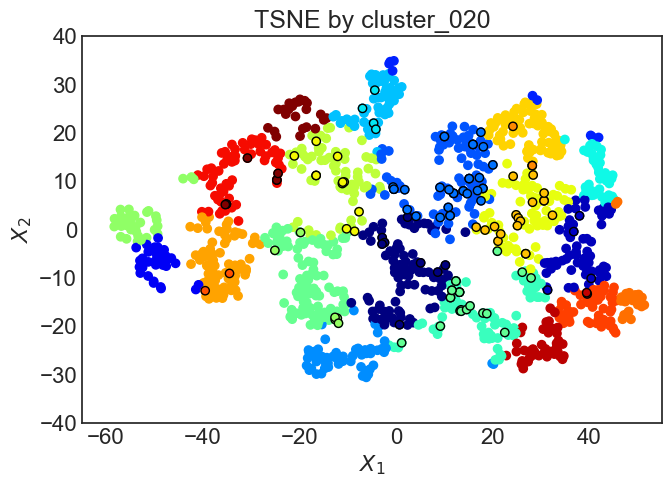

In [33]:
sbnn_embed.emb_color_plot(tsne_final, 'cluster_020', 
                          cmap=plt.get_cmap('jet'), alpha = 1,
                         xlim=[-65,55], ylim=[-40, 40],
                          show_colorbar=False,
                         outfile_folder=Path(setup.temp_path),
                         outfile_prefix = 'A99_PLOT')

## k=100 Clusers (Sub-clusters) 
Split the k=20 clusters, clustering within each.
Do in proportion to cluster size
                         

In [52]:
# Function to return cluster labels within a group
def get_labels(data, n):
    if n <= 1:
        sub_labels = np.full(len(data), 0)
    else:
        sub_labels, _, _, _ = \
            sbnn_embed.get_clusters_silhouettes(data, n)
    
    return pd.Series(sub_labels, name='sub_cluster', index=data.index).to_frame()

In [42]:
np.full(10, 1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [35]:
clus_info_df = tsne_final.groupby('cluster_020') \
    ['tsne_1'] \
    .agg('count') \
    .rename('count') \
    .reset_index()

In [36]:
clus_info_df['n_sub'] = np.round(100 * clus_info_df['count'] / clus_info_df['count'].sum())
clus_info_df['n_sub'] = clus_info_df['n_sub'].astype('int')

In [37]:
clus_ks = dict(zip(clus_info_df['cluster_020'], clus_info_df['n_sub']))

In [40]:
tsne_final

,NAICS,tsne_0,tsne_1,emb_00,emb_01,emb_02,emb_03,emb_04,emb_05,emb_06,emb_07,dset_naics_holdout,NAICS_4,NAICS_3,NAICS_sector,model,cluster_020
0,111110,-56.944935,2.719548,0.829431,-0.429467,-0.846687,-0.688373,0.833410,0.827503,-0.919467,0.813810,0.0,1111,111,11,A01,10
1,111120,-25.674465,15.965102,0.230878,-0.260833,-0.291354,-0.539546,0.470609,0.598844,-0.677097,0.253074,0.0,1111,111,11,A01,17
2,111130,-24.650257,9.622725,0.338633,-0.129188,-0.362890,-0.411735,0.398535,0.529444,-0.632701,0.322125,0.0,1111,111,11,A01,17
3,111140,-52.464993,-5.942733,0.831779,-0.053925,-0.807476,-0.386484,0.664312,0.678779,-0.835418,0.805857,0.0,1111,111,11,A01,2
4,111150,-51.544155,3.623662,0.686245,-0.401735,-0.683646,-0.646142,0.736145,0.786917,-0.860467,0.665350,0.0,1111,111,11,A01,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1190,926140,18.381191,-18.358295,0.278046,0.210496,-0.300474,0.127994,-0.040544,-0.084307,-0.123379,0.270539,0.0,9261,926,92,A01,8
1191,926150,-23.393698,-3.411476,0.381762,-0.145266,-0.451300,-0.287099,0.394303,0.319968,-0.532415,0.391842,0.0,9261,926,92,A01,9
1192,927110,45.441101,5.317651,-0.105108,0.252119,0.180325,0.369074,-0.345754,-0.374105,0.378561,-0.127584,0.0,9271,927,92,A01,15
1193,928110,23.541569,22.869486,-0.212080,-0.154242,0.116414,-0.196657,0.101944,0.029184,-0.111778,-0.122411,0.0,9281,928,92,A01,13


In [49]:
grp = tsne_final.groupby('cluster_020', group_keys=False) 

In [53]:
clus_lbl = pd.concat([get_labels(g[emb_features], clus_ks[n]) for n, g in grp]) \
    .sort_index()

In [54]:
clus_lbl.value_counts()

sub_cluster
0              245
1              239
2              193
4              166
3              159
5               89
7               55
6               44
8                5
Name: count, dtype: int64

In [55]:
# Add labels to tsne
tsne_final = pd.concat([tsne_final.drop(columns='cluster_100', errors='ignore'),
                     clus_lbl.rename(columns={'sub_cluster':'cluster_100'}) \
                     [['cluster_100']]],
                    axis=1)

In [56]:
tsne_final.drop_duplicates(['cluster_020', 'cluster_100']).shape

(100, 18)

In [57]:
tsne_final.drop_duplicates(['cluster_020']).shape

(20, 18)

In [58]:
tsne_final.drop_duplicates(['cluster_100']).shape

(9, 18)

## Get final labels

In [59]:
tsne_final['category_number'] = tsne_final['cluster_020'] 

In [60]:
cat_info = tsne_final[['cluster_020', 'cluster_100']].drop_duplicates() \
    .sort_values(['cluster_020', 'cluster_100'])
cat_info['category_number'] = tsne_final['cluster_020'] 

In [61]:
cat_info['sub_category_number'] = np.arange(len(cat_info))

In [62]:
cat_info['category_name'] = cat_info['category_number'].apply(lambda x: f'{x:02d}')

In [63]:
cat_info['sub_category_name'] = cat_info['category_name'] + \
    cat_info['cluster_100'].apply(lambda x: f'{x:02d}')

In [64]:
new_col = [c for c in cat_info.columns if c not in ['cluster_020', 'cluster_100']]

In [65]:
tsne_final = tsne_final.drop(columns=new_col, errors='ignore') \
    .merge(cat_info, how='left', on=['cluster_020', 'cluster_100'])

In [66]:
tsne_final.drop_duplicates(['sub_category_name']).shape

(100, 22)

In [67]:
tsne_final.drop_duplicates(['sub_category_number']).shape

(100, 22)

In [68]:
tsne_final.to_parquet(Path(setup.temp_path).joinpath('A99_DATA_embeddings_clusters.parquet'))
tsne_final.to_csv(Path(setup.temp_path).joinpath('A99_DATA_embeddings_clusters.csv'),
              index=False)

<Axes: title={'center': 'TSNE by cluster_100'}, xlabel='$X_1$', ylabel='$X_2$'>

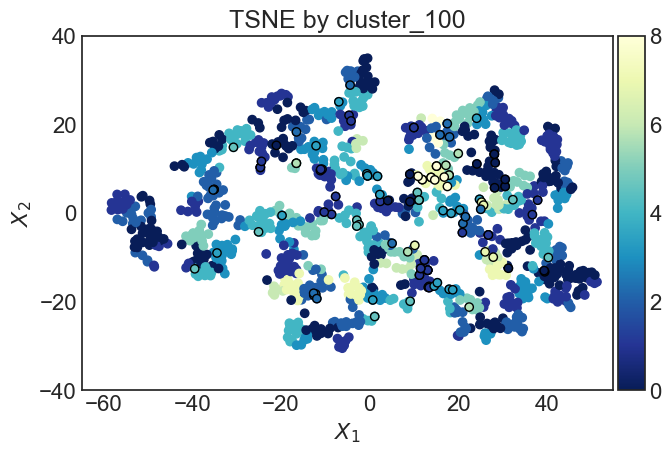

In [69]:
sbnn_embed.emb_color_plot(tsne_final, 'cluster_100', 
                          cmap=plt.get_cmap('YlGnBu_r'), alpha = 1,
                         xlim=[-65,55], ylim=[-40, 40],
                          show_colorbar=True,
                         outfile_folder=Path(setup.temp_path),
                         outfile_prefix = 'A99_PLOT')

<Axes: title={'center': 'TSNE by sub_category_number'}, xlabel='$X_1$', ylabel='$X_2$'>

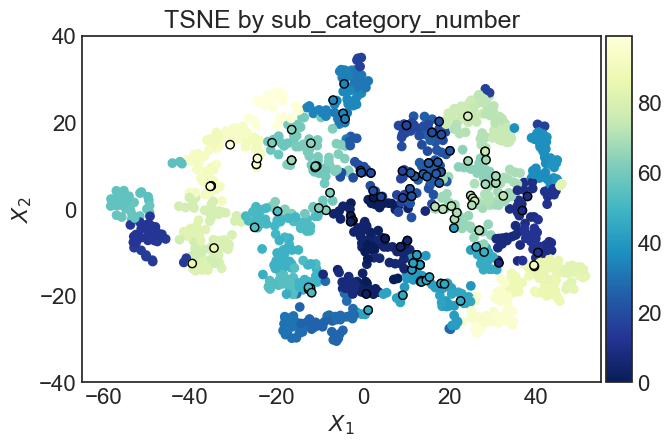

In [70]:
sbnn_embed.emb_color_plot(tsne_final, 'sub_category_number', 
                          cmap=plt.get_cmap('YlGnBu_r'), alpha = 1,
                         xlim=[-65,55], ylim=[-40, 40],
                          show_colorbar=True,
                         outfile_folder=Path(setup.temp_path),
                         outfile_prefix = 'A99_PLOT')